In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
df_flights = pd.read_csv("flight_data.csv")


In [344]:
df_flights_original = df_flights #backedup dataset

In [345]:
df_flights.dropna(subset = ['dep_delay', 'distance', 'hour', 'minute'], how="any", inplace=True)

In [389]:
df_flights["arr_delay"].fillna(value=0, inplace=True)

In [346]:

#Calculated aircraft air speed
#Selected: Added a column for calculated speed
df_flights['speed'] = df_flights.distance/df_flights.air_time

In [348]:
df_flights["ontime"] = np.where(df_flights.dep_delay <= 0, True, False)

In [349]:
df_flights["ontime_arr"] = np.where(df_flights.arr_delay <= 0, True, False)

In [412]:
#Time caught up by the flight as percentage of airtime. negative means the flight was eventually late
def catch_up(arr, dep, airtime):
    return -(dep-arr)/airtime*100

#df['catch_up'] = df.apply(lambda x: catch_up(x['arr_delay'], x['dep_delay']), axis=1)
df_flights["catch_up_of_airtime"] = df_flights.apply(lambda x: catch_up(x['arr_delay'], x['dep_delay'], x['air_time']), axis=1)

#sns.lmplot(data=df_flights, x="distance", y="catch up")


In [369]:
#Data cleaning. There were rows with scheduled departure times within 5-10 mins for the same of set of source, origin, carrier.
# Since each schedule is uniquely identified by Sched departure time, origin, destination and carrier, there cannot be multiples.
# Still there were flights such as 5:05, 5:10, 5:00 for the same origin, dest, carrier.
# Cleaned the data by rounding off their scheduled departure timings.
import math
def roundup(x):
    return int(math.floor(x / 10.0)) * 10
#df_flights["schedule"] = 
df_flights["rounded_schedules"] = df_flights.sched_dep_time.apply(roundup).astype(str) + df_flights.origin + df_flights.dest + df_flights.carrier

In [352]:
#Selected: Some flights (about 35442) happened to make up for lost time and arrived on time despite a delay
df_flights["recovered"] = ((df_flights.dep_delay > 0) & (df_flights.arr_delay <= 0)) 

In [353]:
#sns.barplot(x="hour",y="hour",data=df_flights, hue="ontime"
#df_flights.groupby("hour")
flights_by_hour=df_flights.groupby(["hour", "ontime"]).size().unstack()
#sns.barplot(x="hour",data=df_flights, hue="origin",y="hour",estimator=(lambda x: len(x)/len(df_flights)),)
#sns.countplot(x="hour", data=df_flights.groupby(["hour", "ontime"]).size().unstack())

In [85]:
#df_flights.describe()
#df_flights.info()
# Created an actual date column out of year, month, day
df_flights['date_of_flight'] = pd.to_datetime(df_flights.year*10000 + df_flights.month*100 + df_flights.day,format='%Y%m%d')

0   2013-01-01
1   2013-01-01
2   2013-01-01
3   2013-01-01
4   2013-01-01
Name: date_of_flight, dtype: datetime64[ns]

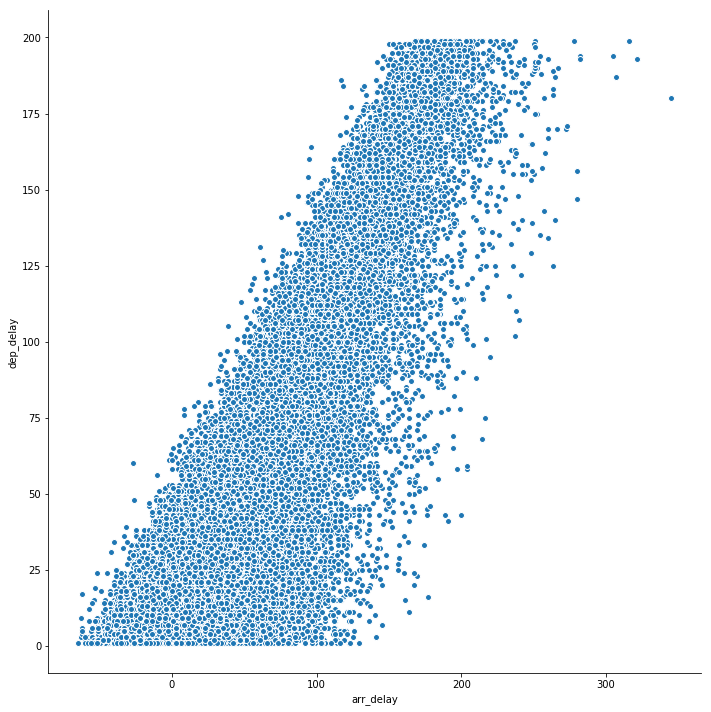

In [6]:
# Mapping arrival and departure delays for flights that had a delayed departue of less than 200 hrs
sns.pairplot(df_flights[(df_flights.dep_delay > 0) & (df_flights.dep_delay < 200)], 
             x_vars = "arr_delay", y_vars = "dep_delay", kind="scatter",size=10)

In [7]:
df_flights.dep_delay.head()

0    2.0
1    4.0
2    2.0
3   -1.0
4   -6.0
Name: dep_delay, dtype: float64

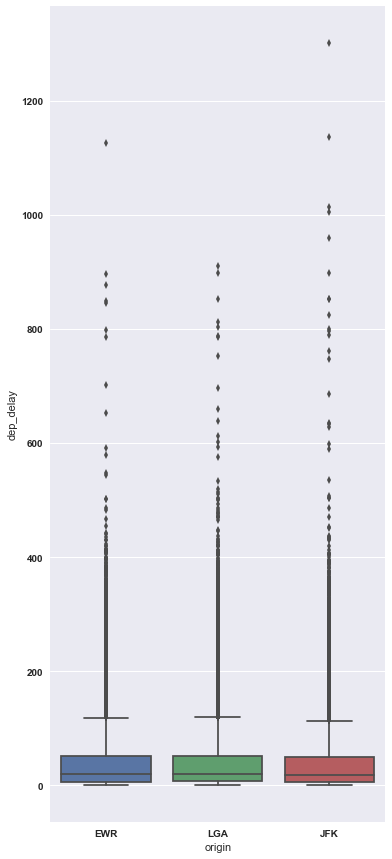

In [350]:
#Selected: (Analysis of delayed flights)
"""<Majority of the departure delays were under 200 mins. 
As the box plots below show, the flights with departure delayed beyond 200 mins were outliers.
"""
#df_flights[df_flights["dep_delay"] > 600
sns.set(rc={'figure.figsize':(6,15)})
g = sns.boxplot(data=df_flights[df_flights["dep_delay"] > 0], 
              x="origin", y="dep_delay")

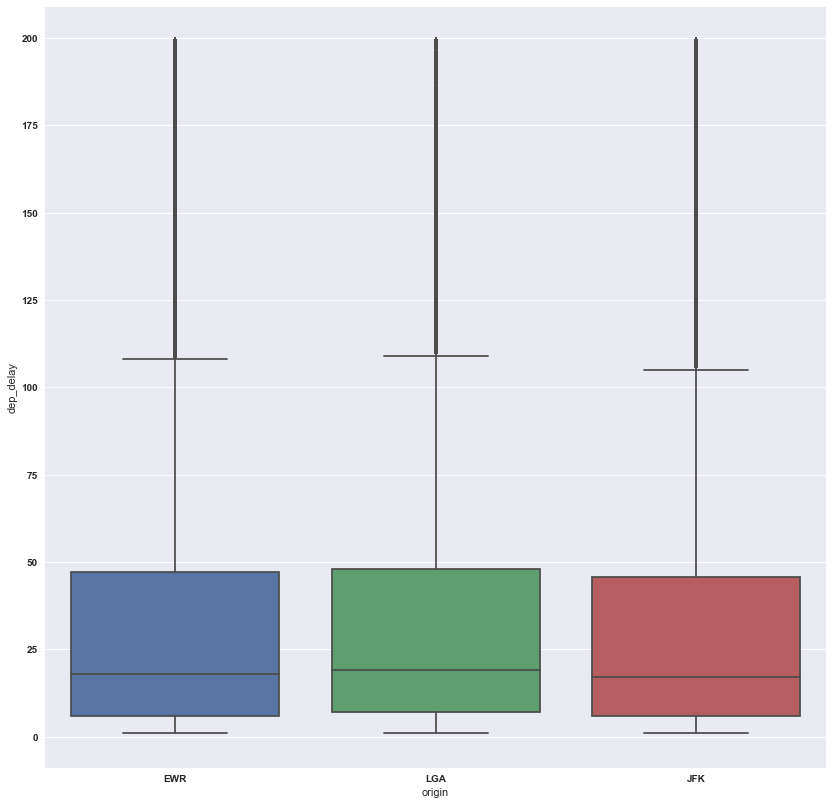

In [351]:
#Selected: (Analysis of delayed flights)
"""If we remove the outliers we notice that the pattern is similar for all 3 airports
25% of the delays are between 20 to 50 mins, another 25% between 5 to 20 mins"""

sns.set(rc={'figure.figsize':(14,14)})
g = sns.boxplot(data=df_flights[(df_flights["dep_delay"] > 0) & (df_flights["dep_delay"] < 200)], 
              x="origin", y="dep_delay")

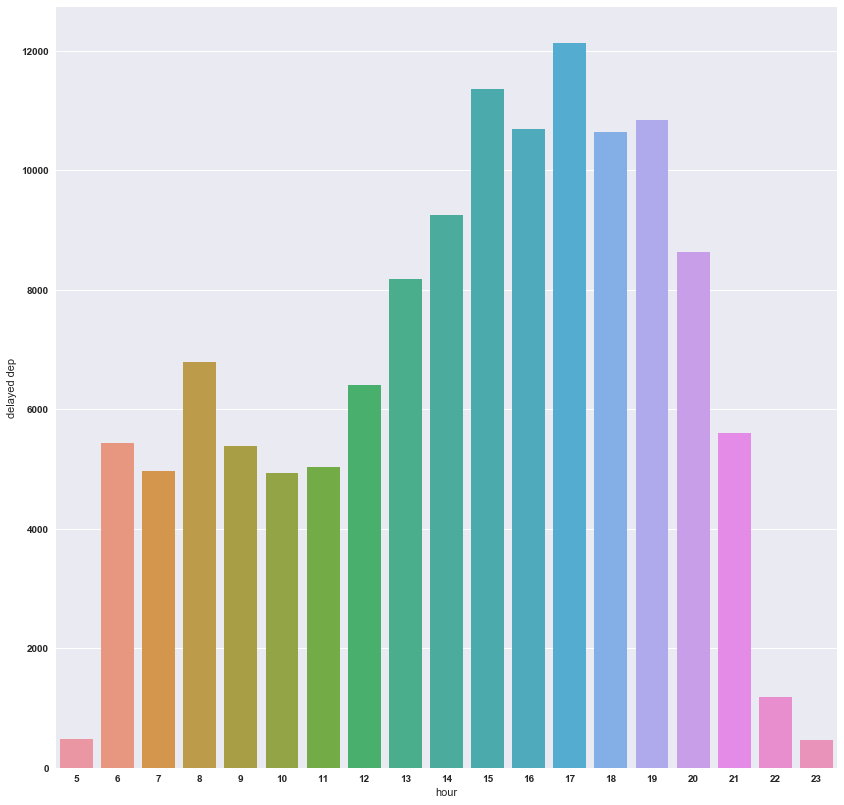

In [354]:
flights_by_hour.columns=['delayed dep','ontime dep']
flights_by_hour
sns.barplot(x=flights_by_hour.index,y=flights_by_hour['delayed dep'], data=flights_by_hour, color=None)

In [355]:
#Aggregation by Carrier
df_flights_agg_carrier = (df_flights.groupby('carrier')
.agg({'speed':'mean', 
      'dep_delay': 'mean', 
      'arr_delay': 'mean', 
      'flight':'count' , 
      'ontime':'mean', 
      'ontime_arr':'mean',
      'recovered':'mean'}).reset_index()
.rename(columns={'speed':'Average Speed',
                 'dep_delay': 'Average Departure Delay',
                 'arr_delay': 'Average Arrival Delay',
                 'flight': 'No of flights',
                 'ontime':'ontime departure percentage',
                 'ontime_arr':'ontime arrival percentage',
                 'recovered':'recovery percentage'})
)
df_flights_agg_carrier

,carrier,Average Speed,Average Departure Delay,Average Arrival Delay,No of flights,ontime departure percentage,ontime arrival percentage,recovery percentage
0,9E,5.757173,16.725769,7.379669,17416,0.594453,0.611909,0.110531
1,AA,6.957879,8.586016,0.364291,32093,0.683358,0.661858,0.107095
2,AS,7.394648,5.804775,-9.930889,712,0.682584,0.730337,0.140449
3,B6,6.666191,13.022522,9.457973,54169,0.604109,0.561945,0.091122
4,DL,6.974380,9.264505,1.644341,47761,0.680890,0.654195,0.105944
5,EV,6.049060,19.955390,15.796431,51356,0.549439,0.518420,0.073857
6,F9,7.086202,20.215543,21.920705,682,0.500000,0.423754,0.123167
7,FL,6.572635,18.726075,20.115906,3187,0.481017,0.401632,0.081895
8,HA,8.005962,4.900585,-6.915205,342,0.798246,0.716374,0.093567
9,MQ,6.140047,10.552041,10.774733,25163,0.680841,0.530302,0.040615


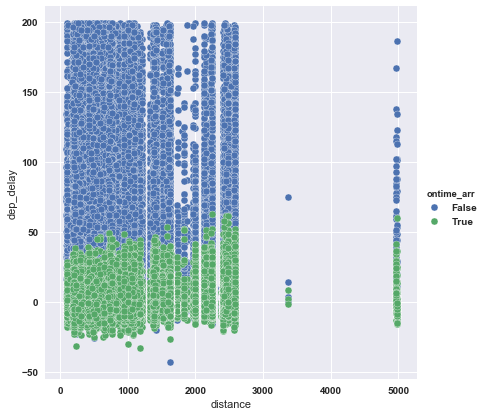

In [356]:
#Selected:
"""Beyond a delay of about 50 mins, flights are not able to catch up and still arrive on time"""
sns.set_style()
sns.pairplot(df_flights[df_flights['dep_delay'] < 200], x_vars='distance', y_vars='dep_delay',size=6, hue='ontime_arr')

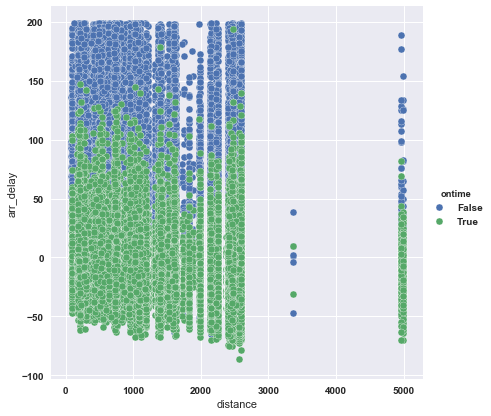

In [357]:
sns.pairplot(df_flights[df_flights['arr_delay'] < 200], x_vars='distance', y_vars='arr_delay',size=6, hue='ontime')

In [358]:
df_flights_agg_carrier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 8 columns):
carrier                        16 non-null object
Average Speed                  16 non-null float64
Average Departure Delay        16 non-null float64
Average Arrival Delay          16 non-null float64
No of flights                  16 non-null int64
ontime departure percentage    16 non-null float64
ontime arrival percentage      16 non-null float64
recovery percentage            16 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 1.1+ KB


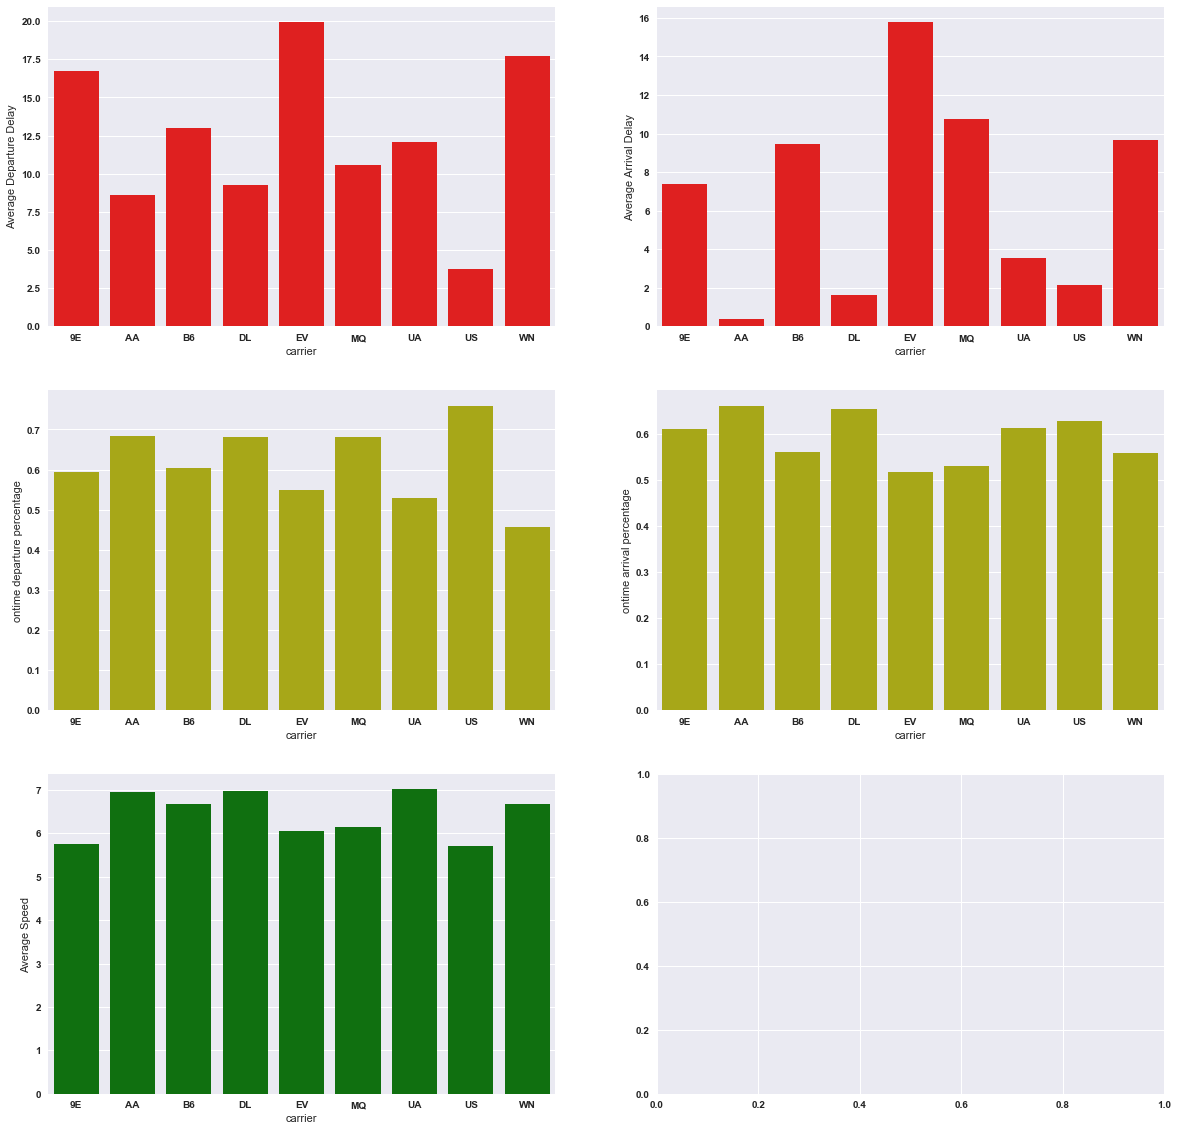

In [359]:
%matplotlib inline
df_agg = df_flights_agg_carrier[df_flights_agg_carrier['No of flights'] > 10000]
fig, ((ax1, ax2), (ax3,ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3,figsize=(20,20))

#sns.color_palette("BrBG", 
sns.barplot(x='carrier', y='Average Speed', data=df_agg, ax=ax5, color='g',)
sns.barplot(x='carrier', y='Average Departure Delay', data=df_agg, ax=ax1, color='r')
sns.barplot(x='carrier', y='Average Arrival Delay', data=df_agg, ax=ax2, color='r')
sns.barplot(x='carrier', y='ontime departure percentage', data=df_agg, ax=ax3, color='y')
sns.barplot(x='carrier', y='ontime arrival percentage', data=df_agg, ax=ax4, color='y')

#labels = ax.get_xticklabels() 
#ax.set_xticklabels(labels, rotation=-30)



plt.show()

In [388]:
#Aggregation on origin airport
df_flights_agg_origin = (df_flights.groupby('origin')
.agg({'speed':'mean', 
      'dep_delay': 'mean', 
      'arr_delay': 'mean', 
      'flight':'count' , 
      'ontime':'mean', 
      'ontime_arr':'mean',
      'recovered':'mean',
      }).reset_index()
.rename(columns={'speed':'Average Speed', 
                 'dep_delay': 'Average Departure Delay', 
                 'arr_delay': 'Average Arrival Delay',
                 'flight': 'No of flights',
                 'ontime':'ontime departure percentage', 
                 'ontime_arr':'ontime arrival percentage',
                 'recovered':'recovery percentage'})
)
df_flights_agg_origin.head()

,origin,Average Speed,Average Departure Delay,Average Arrival Delay,No of flights,ontime departure percentage,ontime arrival percentage,recovery percentage
0,EWR,6.599225,15.107954,9.107055,117596,0.551762,0.569985,0.125361
1,JFK,6.642058,12.112159,5.551481,109416,0.615861,0.604976,0.114334
2,LGA,6.462414,10.346876,5.783488,101509,0.668108,0.602114,0.080683


In [387]:
#Aggregation on destination
df_flights_agg_dest = (df_flights.groupby('dest')
.agg({'speed':'mean', 
      'dep_delay': 'mean', 
      'arr_delay': 'mean', 
      'flight':'count' , 
      'ontime':'mean', 
      'ontime_arr':'mean',
      'recovered':'mean',
      }).reset_index()
.rename(columns={'speed':'Average Speed', 
                 'dep_delay': 'Average Departure Delay', 
                 'arr_delay': 'Average Arrival Delay',
                 'flight': 'No of flights',
                 'ontime':'ontime departure percentage', 
                 'ontime_arr':'ontime arrival percentage',
                 'recovered':'recovery percentage'})
)
df_flights_agg_dest.head()

,dest,Average Speed,Average Departure Delay,Average Arrival Delay,No of flights,ontime departure percentage,ontime arrival percentage,recovery percentage
0,ABQ,7.370106,13.740157,4.381890,254,0.547244,0.578740,0.149606
1,ACK,4.815894,6.456604,4.852273,265,0.690566,0.603774,0.037736
2,ALB,4.538350,23.620525,14.397129,419,0.498807,0.558473,0.095465
3,ANC,8.166432,12.875000,-2.500000,8,0.250000,0.375000,0.250000
4,ATL,6.753035,12.509824,11.300113,16898,0.640135,0.526157,0.073618


In [361]:
df_flights_agg_dest.set_index("dest", inplace=True)

In [362]:
#ORD i.e. Chicago has most flights coming to it
print(df_flights_agg_dest["No of flights"].argmax())

#CAE i.e. has most flights coming to it
print(df_flights_agg_dest["Average Departure Delay"].argmax())

ATL
CAE


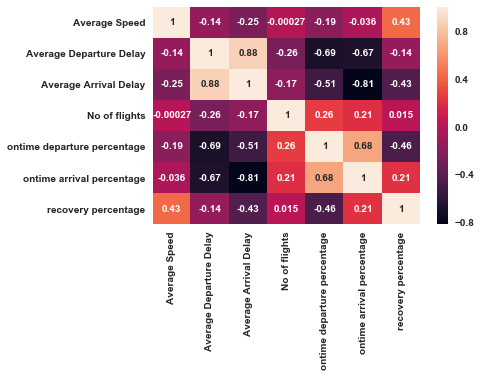

In [363]:
sns.heatmap(df_flights_agg_dest.corr(),annot=True)
# There is very little correlation between Speed and delay. 

In [364]:
#Busiest destinations
df_busy_dests = df_flights_agg_dest[df_flights_agg_dest["No of flights"]>10000].sort_values(['No of flights'],ascending=False).index

In [365]:
df_busy_dests

Index(['ATL', 'ORD', 'LAX', 'BOS', 'MCO', 'CLT', 'SFO', 'FLL', 'MIA'], dtype='object', name='dest')

In [366]:
df_flights[df_flights['dest'].isin(list(df_busy_dests))]

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,distance,hour,minute,time_hour,speed,ontime,ontime_arr,recovered,rounded_schedules,catch up ratio
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,1089,5,40,01-01-2013 05:00,6.806250,False,False,False,540JFKMIAAA,-31.0
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,...,762,6,0,01-01-2013 06:00,6.568966,True,True,False,600LGAATLDL,19.0
5,2013,1,1,554.0,558,-4.0,740.0,728,12.0,UA,...,719,5,58,01-01-2013 05:00,4.793333,True,False,False,550EWRORDUA,-16.0
6,2013,1,1,555.0,600,-5.0,913.0,854,19.0,B6,...,1065,6,0,01-01-2013 06:00,6.740506,True,False,False,600EWRFLLB6,-24.0
8,2013,1,1,557.0,600,-3.0,838.0,846,-8.0,B6,...,944,6,0,01-01-2013 06:00,6.742857,True,True,False,600JFKMCOB6,5.0
9,2013,1,1,558.0,600,-2.0,753.0,745,8.0,AA,...,733,6,0,01-01-2013 06:00,5.311594,True,False,False,600LGAORDAA,-10.0
12,2013,1,1,558.0,600,-2.0,924.0,917,7.0,UA,...,2475,6,0,01-01-2013 06:00,7.173913,True,False,False,600JFKLAXUA,-9.0
13,2013,1,1,558.0,600,-2.0,923.0,937,-14.0,UA,...,2565,6,0,01-01-2013 06:00,7.105263,True,True,False,600EWRSFOUA,12.0
15,2013,1,1,559.0,559,0.0,702.0,706,-4.0,B6,...,187,5,59,01-01-2013 05:00,4.250000,True,True,False,550JFKBOSB6,4.0
17,2013,1,1,600.0,600,0.0,851.0,858,-7.0,B6,...,1076,6,0,01-01-2013 06:00,7.078947,True,True,False,600LGAFLLB6,7.0


In [367]:
#Aggregation by month of year
df_flights_agg_month = (df_flights.groupby('month')
.agg({'speed':'mean', 
      'dep_delay': 'mean', 
      'arr_delay': 'mean', 
      'flight':'count' , 
      'ontime':'mean', 
      'ontime_arr':'mean',
      'recovered':'mean',
      }).reset_index()
.rename(columns={'speed':'Average Speed', 
                 'dep_delay': 'Average Departure Delay', 
                 'arr_delay': 'Average Arrival Delay',
                 'flight': 'No of flights',
                 'ontime':'ontime departure percentage', 
                 'ontime_arr':'ontime arrival percentage',
                 'recovered':'recovery percentage'})
).set_index("month")


"""Average delays are higher in May, June and December (both departure and arrival). They are vacation/holiday months
Delays could possibly be due to heavy baggage movements and chaos at the airport. Need more data on traveller type and behavior.
Hence the delays 

Average departure delays were also high Jan-April and in July, but about half the delay was made up for in most cases.

"""
#Selected

'Average delays are higher in May, June and December (both departure and arrival). They are vacation/holiday months\nDelays could possibly be due to heavy baggage movements and chaos at the airport. Need more data on traveller type and behavior.\nHence the delays \n\nAverage departure delays were also high Jan-April and in July, but about half the delay was made up for in most cases.\n\n'

In [368]:
#del df_flights["date_of_flight"]

In [370]:

#Selected:
# 13825 flights
df_flights["rounded_schedules"].size

328521

In [371]:
#  a particular flight is identified by its carrier, origin, destination and scheduled time of departure
#Aggegration by schedule
df_by_flight_schedules = (df_flights.groupby(['rounded_schedules'])
.agg({'speed':'mean', 
      'dep_delay': 'mean', 
      'arr_delay': 'mean',
      'flight':'count' , 
      'ontime':'mean', 
      'ontime_arr':'mean',
      'recovered':'mean',
      }).reset_index()
.rename(columns={'speed':'Average Speed', 
                 'dep_delay': 'Average Departure Delay', 
                 'arr_delay': 'Average Arrival Delay',
                 'flight': 'No of flights',
                 'ontime':'ontime departure percentage', 
                 'ontime_arr':'ontime arrival percentage',
                 'recovered':'recovery percentage'})
                         ).set_index("rounded_schedules")
df_by_flight_schedules.head()

,Average Speed,Average Departure Delay,Average Arrival Delay,No of flights,ontime departure percentage,ontime arrival percentage,recovery percentage
rounded_schedules,,,,,,,
1000EWRALBEV,4.333333,6.000000,-12.000000,1,0.000000,1.000000,1.000000
1000EWRATLEV,6.379547,19.142857,15.904762,21,0.714286,0.476190,0.047619
1000EWRBNAEV,6.498039,10.136364,4.484848,66,0.651515,0.636364,0.106061
1000EWRBOSEV,5.315640,-7.333333,-22.000000,3,1.000000,1.000000,0.000000
1000EWRBOSUA,5.099199,2.553846,-5.384615,65,0.800000,0.846154,0.107692


In [372]:
#Selected
"""Still lets remove schedules with very few flights as an aberration"""
df_by_flight_schedules.sort_values(by=["No of flights"], ascending=False).head(10)

,Average Speed,Average Departure Delay,Average Arrival Delay,No of flights,ontime departure percentage,ontime arrival percentage,recovery percentage
rounded_schedules,,,,,,,
1310EWRCLTUS,6.399958,-0.476584,-1.707182,363,0.859504,0.652893,0.035813
1200JFKLAXAA,7.611475,0.740331,-8.160221,362,0.809392,0.743094,0.071823
540JFKMIAAA,7.307025,0.693370,-9.681440,362,0.745856,0.781768,0.149171
1630JFKSFOVX,7.375268,27.444751,15.132964,362,0.378453,0.577348,0.265193
1650JFKLAXVX,7.403348,18.209945,6.994444,362,0.325967,0.582873,0.325967
2350JFKPSEB6,8.010916,10.163889,7.837535,360,0.577778,0.500000,0.094444
1340JFKLAXAA,7.518161,5.397222,-6.263889,360,0.775000,0.769444,0.102778
630LGACLTUS,6.144102,-0.902507,-9.600559,359,0.908078,0.802228,0.047354
600LGAFLLB6,7.268776,-3.203343,-6.350975,359,0.871866,0.754875,0.036212


In [176]:
df_by_flight_schedules.index.size

7200

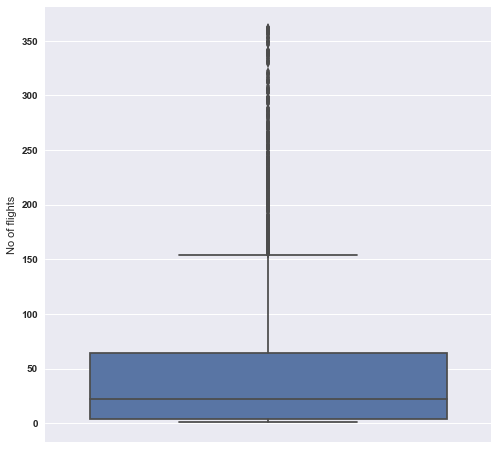

In [373]:
#Most flights in the datasets were the ones that flew only 6 to 66 times a year. They may not have been regular flights.
# The outliers are the flights that flew once in two days or almost daily. 

fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(df_by_flight_schedules["No of flights"],width=0.8,orient="vertical")

In [374]:
df_by_flight_schedules["No of flights"].describe()

count    7186.00000
mean       45.71681
std        62.30067
min         1.00000
25%         4.00000
50%        22.00000
75%        64.00000
max       363.00000
Name: No of flights, dtype: float64

24202


C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


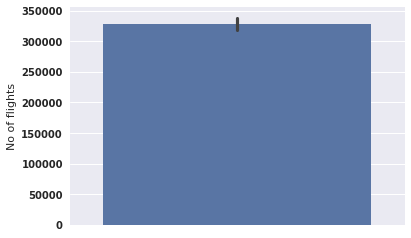

In [375]:
print(df_by_flight_schedules[df_by_flight_schedules["No of flights"] > 300]["No of flights"].sum())
import matplotlib as mp
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

mp.rc('font', **font)
sns.barplot(df_by_flight_schedules["No of flights"], estimator=sum, orient='v',)

In [376]:
# We need to quartile the schedules, so we group flights with frequencies in each quartile
df_by_flight_schedules["Ranges"] = pd.Series(pd.qcut(df_by_flight_schedules["No of flights"], 4, labels=None, retbins=False, precision=0, duplicates='drop'))

In [377]:
df_by_flight_schedules.head(5) 

,Average Speed,Average Departure Delay,Average Arrival Delay,No of flights,ontime departure percentage,ontime arrival percentage,recovery percentage,Ranges
rounded_schedules,,,,,,,,
1000EWRALBEV,4.333333,6.000000,-12.000000,1,0.000000,1.000000,1.000000,"(0.0, 4.0]"
1000EWRATLEV,6.379547,19.142857,15.904762,21,0.714286,0.476190,0.047619,"(4.0, 22.0]"
1000EWRBNAEV,6.498039,10.136364,4.484848,66,0.651515,0.636364,0.106061,"(64.0, 363.0]"
1000EWRBOSEV,5.315640,-7.333333,-22.000000,3,1.000000,1.000000,0.000000,"(0.0, 4.0]"
1000EWRBOSUA,5.099199,2.553846,-5.384615,65,0.800000,0.846154,0.107692,"(64.0, 363.0]"


'Majority of the flights are '

C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


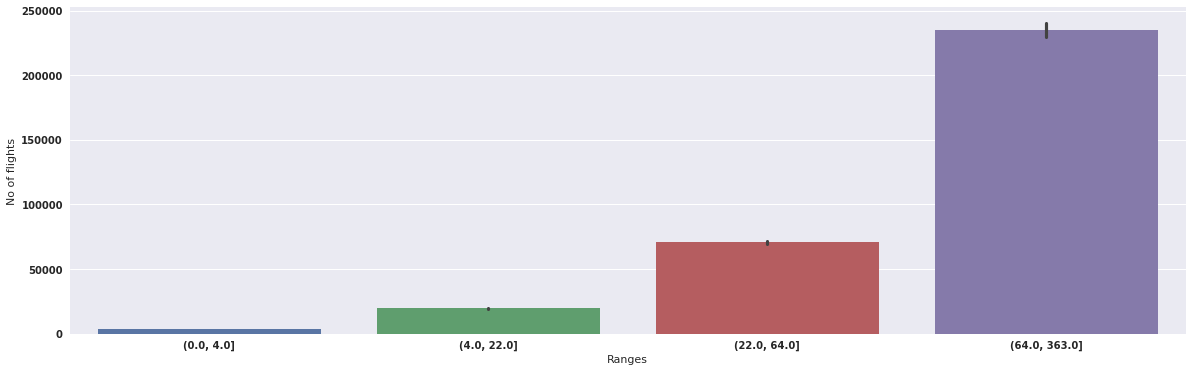

In [391]:
#4th quartile has less schedules 
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(x = "Ranges", y = "No of flights", data=df_by_flight_schedules, estimator=sum, orient='v')
"""Majority of the flights are """

C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


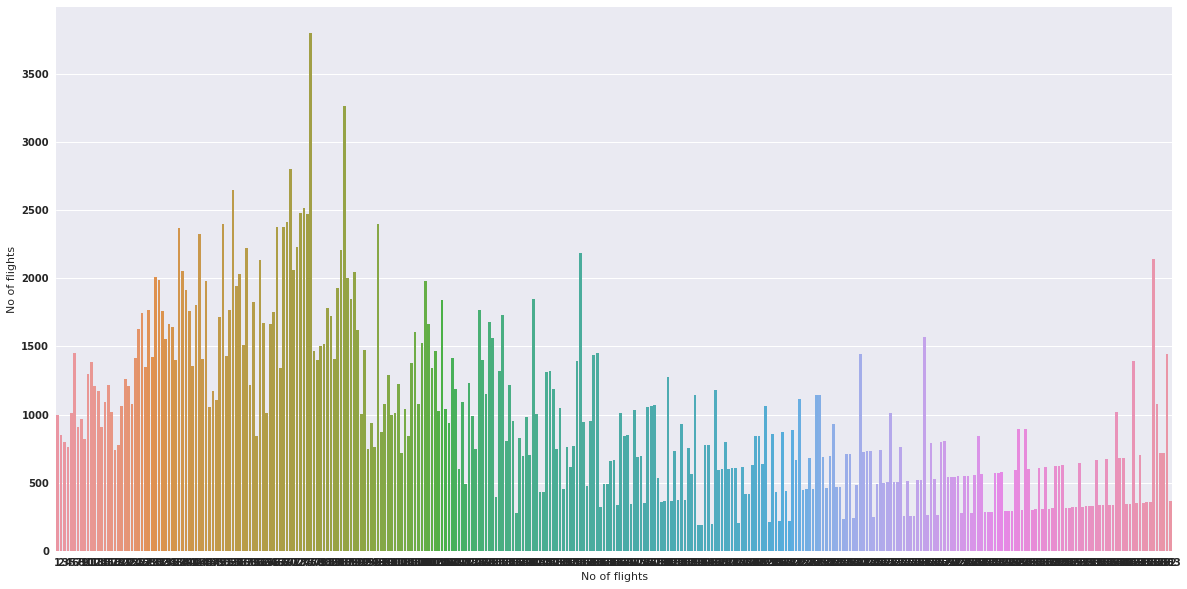

In [379]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x = "No of flights", y = "No of flights", data=df_by_flight_schedules, estimator=sum, orient='v')

In [380]:
type(df_flights["dep_delay"].argmax())

numpy.int64

In [381]:
df_flights.loc[df_flights["dep_delay"].argmax()]

year                             2013
month                               1
day                                 9
dep_time                          641
sched_dep_time                    900
dep_delay                        1301
arr_time                         1242
sched_arr_time                   1530
arr_delay                        1272
carrier                            HA
flight                             51
tailnum                        N384HA
origin                            JFK
dest                              HNL
air_time                          640
distance                         4983
hour                                9
minute                              0
time_hour            09-01-2013 09:00
speed                         7.78594
ontime                          False
ontime_arr                      False
recovered                       False
rounded_schedules         900JFKHNLHA
catch up ratio                     29
Name: 7072, dtype: object

In [430]:
df_flights[["air_time","dep_delay","arr_delay", "speed","catch_up_of_airtime"]][df_flights["catch_up_of_airtime"] < 0].head(5)

,air_time,dep_delay,arr_delay,speed,catch_up_of_airtime
3,183.0,-1.0,-18.0,8.612022,-9.289617
4,116.0,-6.0,-25.0,6.568966,-16.379310
7,53.0,-3.0,-14.0,4.320755,-20.754717
8,140.0,-3.0,-8.0,6.742857,-3.571429
11,158.0,-2.0,-3.0,6.360759,-0.632911


In [383]:
df_by_flight_schedules.head(5)

,Average Speed,Average Departure Delay,Average Arrival Delay,No of flights,ontime departure percentage,ontime arrival percentage,recovery percentage,Ranges
rounded_schedules,,,,,,,,
1000EWRALBEV,4.333333,6.000000,-12.000000,1,0.000000,1.000000,1.000000,"(0.0, 4.0]"
1000EWRATLEV,6.379547,19.142857,15.904762,21,0.714286,0.476190,0.047619,"(4.0, 22.0]"
1000EWRBNAEV,6.498039,10.136364,4.484848,66,0.651515,0.636364,0.106061,"(64.0, 363.0]"
1000EWRBOSEV,5.315640,-7.333333,-22.000000,3,1.000000,1.000000,0.000000,"(0.0, 4.0]"
1000EWRBOSUA,5.099199,2.553846,-5.384615,65,0.800000,0.846154,0.107692,"(64.0, 363.0]"


C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


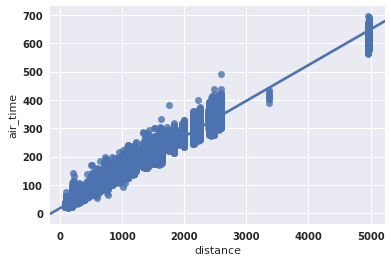

In [429]:
sns.regplot(y="air_time", x="distance", data=df_flights,)
#Air time fluctuate in the range of about 60 to 130 mins.
# Notice in another chart that delays range about 50 to 90 mins

C:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


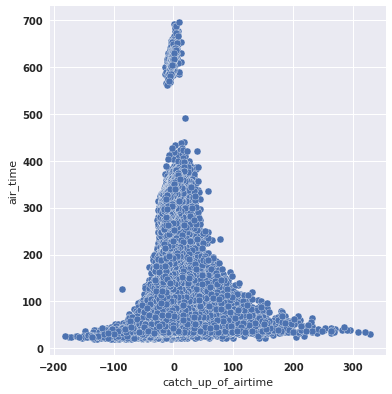

In [425]:
# Short duration flights seem more unpredictable as the time caught up or lost fluctuates a lot.
sns.pairplot(y_vars="air_time", x_vars="catch_up_of_airtime", data=df_flights, size=6)

In [384]:
#Let's pick only those flights whose schedules are more frequent i.e. 4th quartile (66 to 365). They must be weekly to daily and 
# definitely not adhoc
df_most_frequent_flights = df_flights[df_flights["rounded_schedules"].isin(df_by_flight_schedules[df_by_flight_schedules["Ranges"] == pd.Interval(66.0,365.0)].index)]
#df_by_flight_schedules["Ranges"] == pd.Interval(66.0,365.0)
#type(df_by_flight_schedules["Ranges"][0])
#df_y["rounded_schedules"].size
df_most_frequent_flights.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,distance,hour,minute,time_hour,speed,ontime,ontime_arr,recovered,rounded_schedules,catch up ratio
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,...,1400,5,15,01-01-2013 05:00,6.167401,False,False,False,510EWRIAHUA,-9.0
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,...,1089,5,40,01-01-2013 05:00,6.806250,False,False,False,540JFKMIAAA,-31.0


In [385]:
df_most_frequent_flights.sort_values(["dep_delay"], ascending=False).head(3)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,distance,hour,minute,time_hour,speed,ontime,ontime_arr,recovered,rounded_schedules,catch up ratio
7072,2013,1,9,641.0,900,1301.0,1242.0,1530,1272.0,HA,...,4983,9,0,09-01-2013 09:00,7.785938,False,False,False,900JFKHNLHA,29.0
235778,2013,6,15,1432.0,1935,1137.0,1607.0,2120,1127.0,MQ,...,483,19,35,15-06-2013 19:00,6.527027,False,False,False,1930JFKCMHMQ,10.0
8239,2013,1,10,1121.0,1635,1126.0,1239.0,1810,1109.0,MQ,...,719,16,35,10-01-2013 16:00,6.477477,False,False,False,1630EWRORDMQ,17.0


In [394]:
df_most_frequent_flights["rounded_schedules"].head(2)

0    510EWRIAHUA
2    540JFKMIAAA
Name: rounded_schedules, dtype: object